In [1]:
import cv2
import os
import numpy as np
import random
import shutil
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
os.listdir('dataset')

['geblek-renteng',
 'gentongan',
 'liong',
 'mega-mendung',
 'parang',
 'sekar-jagad',
 'sidomukti',
 'tambal',
 'truntum',
 'tujuh-rupa']

In [3]:
# Resize function
def resize_image(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

In [4]:
def main():
    # Path ke direktori input gambar
    input_base_path = 'dataset/'
    
    # Path ke direktori output gambar
    output_base_path = 'output_dataset/'

    # Loop melalui setiap folder
    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)
        output_folder_path = os.path.join(output_base_path, folder_name)

        # Membuat direktori output jika belum ada
        os.makedirs(output_folder_path, exist_ok=True)

        # Loop melalui setiap file dalam folder input
        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)
            output_image_path = os.path.join(output_folder_path, filename)

            # Pastikan file adalah file gambar
            if os.path.isfile(input_image_path):
                try:
                    # Baca gambar
                    image = cv2.imread(input_image_path)

                    # Resize gambar
                    resized_image = resize_image(image)

                    # Simpan gambar yang telah diresize
                    cv2.imwrite(output_image_path, resized_image)
                except Exception as e:
                    print(f"Error resizing image {filename} pada folder {folder_name}: {str(e)}")

    print("Image resizing completed.")

In [5]:
if __name__ == "__main__":
    main()

Image resizing completed.


In [6]:
def min_max_normalize_image(image):
    # Konversi tipe data gambar ke float32
    image = image.astype('float32')

    # Normalisasi dengan Min-Max Scaling
    min_val = np.min(image)
    max_val = np.max(image)
    if min_val == max_val:
        return np.zeros_like(image)
    else:
        normalized_image = (image - min_val) / (max_val - min_val)
        return normalized_image

In [7]:
def main():
    # Path ke direktori input gambar
    input_base_path = 'output_dataset/'

    # Loop melalui setiap folder di dalam direktori input
    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)

        # Loop melalui setiap file dalam folder input
        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)

            # Pastikan file adalah file gambar
            if os.path.isfile(input_image_path):
                try:
                    # Baca gambar
                    image = cv2.imread(input_image_path)

                    # Normalisasi gambar
                    normalized_image = min_max_normalize_image(image)

                    # Simpan gambar yang telah dinormalisasi (menimpa gambar asli)
                    cv2.imwrite(input_image_path, normalized_image * 255)  # Kembalikan ke rentang 0-255 untuk menyimpan sebagai gambar
                except Exception as e:
                    print(f"Error normalizing image {filename} pada folder {folder_name}: {str(e)}")

    print("Image normalization completed.")

# Panggil fungsi main
if __name__ == "__main__":
    main()

Image normalization completed.


In [8]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Konversi gambar ke ruang warna Lab (L: luminance, a/b: color channels)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Pisahkan saluran L dari gambar Lab
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Terapkan CLAHE ke saluran L
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_l_channel = clahe.apply(l_channel)

    # Gabungkan saluran yang diperbarui L dengan saluran a dan b yang asli
    clahe_image = cv2.merge((enhanced_l_channel, a_channel, b_channel))

    # Konversi kembali gambar ke ruang warna RGB
    enhanced_image = cv2.cvtColor(clahe_image, cv2.COLOR_LAB2BGR)

    return enhanced_image

In [9]:
def main():
    # Path ke direktori input gambar
    input_base_path = 'output_dataset'
    
    # Loop melalui setiap folder di dalam direktori input
    for folder_name in os.listdir(input_base_path):
        input_folder_path = os.path.join(input_base_path, folder_name)

        # Loop melalui setiap file dalam folder input
        for filename in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, filename)

            # Pastikan file adalah file gambar
            if os.path.isfile(input_image_path):
                try:
                    # Baca gambar
                    image = cv2.imread(input_image_path)

                    # Terapkan CLAHE untuk meningkatkan kontras gambar
                    enhanced_image = apply_clahe(image)

                    # Simpan gambar yang telah diperbarui, menggantikan yang lama
                    cv2.imwrite(input_image_path, enhanced_image)
                except Exception as e:
                    print(f"Error enhancing image {filename} pada folder {folder_name}: {str(e)}")

    print("Contrast enhancement with CLAHE completed.")

In [10]:
if __name__ == "__main__":
    main()

Contrast enhancement with CLAHE completed.


In [11]:
def augment_images(input_folder, num_images=10):
    # Membuat objek augmenter untuk augmentasi gambar
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Memutar gambar secara horizontal dengan peluang 50%
        iaa.Affine(rotate=(-20, 20)),  # Rotasi gambar sebesar -20 hingga 20 derajat
        iaa.GaussianBlur(sigma=(0, 1.0)),  # Menambahkan Gaussian blur dengan sigma antara 0 dan 1.0
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Menambahkan Gaussian noise
        iaa.Multiply((0.8, 1.2), per_channel=0.2),  # Mengalikan intensitas pixel dengan faktor antara 0.8 dan 1.2
        iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  # Menormalisasi kontras
    ])

    # Loop melalui setiap folder di dalam direktori input
    for folder_name in os.listdir(input_folder):
        input_folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(input_folder_path):
            continue

        # Mendapatkan daftar semua gambar di folder input
        image_files = [f for f in os.listdir(input_folder_path) if os.path.isfile(os.path.join(input_folder_path, f))]

        # Memilih secara acak gambar dari folder tersebut
        selected_files = random.sample(image_files, min(num_images, len(image_files)))

        # Loop melalui gambar-gambar yang telah dipilih
        for filename in selected_files:
            input_image_path = os.path.join(input_folder_path, filename)
            try:
                # Membaca gambar
                image = cv2.imread(input_image_path)

                # Membuat variasi gambar dengan augmentasi
                images_aug = [seq(image=image) for _ in range(num_images)]

                # Menyimpan gambar-gambar yang telah di-augmentasi dengan menimpa gambar asli
                for idx, image_aug in enumerate(images_aug):
                    output_image_path = os.path.join(input_folder_path, f"{filename.split('.')[0]}_{idx}.jpg")
                    cv2.imwrite(output_image_path, image_aug)

                # Menghapus gambar asli
                os.remove(input_image_path)
            except Exception as e:
                print(f"Error saat melakukan augmentasi untuk gambar {filename} di folder {folder_name}: {str(e)}")

    print("Augmentasi gambar selesai.")

# Path ke direktori input
input_folder_path = 'output_dataset'

# Memanggil fungsi untuk melakukan augmentasi
augment_images(input_folder_path, num_images=10)

Augmentasi gambar selesai.


In [12]:
path = 'output_dataset/'
split_path = 'split_dataset/'

# Membuat folder train, test, dan val di dalam folder split
train_path = os.path.join(split_path, 'train')
test_path = os.path.join(split_path, 'test')
val_path = os.path.join(split_path, 'val')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

In [13]:
# Iterasi melalui setiap subfolder di dalam folder utama 'a'
for subfolder in os.listdir(path):
    subfolder_path = os.path.join(path, subfolder)
    
    # Pastikan yang diiterasi adalah folder (bukan file)
    if os.path.isdir(subfolder_path):
        # Buat folder masing-masing di dalam train, test, val
        train_subfolder_path = os.path.join(train_path, subfolder)
        test_subfolder_path = os.path.join(test_path, subfolder)
        val_subfolder_path = os.path.join(val_path, subfolder)
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)
        os.makedirs(val_subfolder_path, exist_ok=True)
        
        # Ambil daftar file dalam subfolder
        file_list = os.listdir(subfolder_path)
        num_files = len(file_list)
        
        # Hitung jumlah file untuk train, test, val
        num_train = int(0.7 * num_files)
        num_test = int(0.2 * num_files)
        num_val = num_files - num_train - num_test
        
        # Acak urutan file untuk memastikan pembagian random
        random.shuffle(file_list)
        
        # Iterasi dan pindahkan file ke folder masing-masing
        for i, file_name in enumerate(file_list):
            old_path = os.path.join(subfolder_path, file_name)
            
            if i < num_train:
                new_path = os.path.join(train_subfolder_path, file_name)
            elif i < num_train + num_test:
                new_path = os.path.join(test_subfolder_path, file_name)
            else:
                new_path = os.path.join(val_subfolder_path, file_name)
            
            # Pindahkan file ke folder baru
            shutil.copy(old_path, new_path)  # Menggunakan shutil.copy untuk menyalin, bukan shutil.move
            
print("File-file berhasil dibagi ke dalam folder train, test, dan val.")

File-file berhasil dibagi ke dalam folder train, test, dan val.


In [14]:
train_dir = 'split_dataset/train/'
val_dir = 'split_dataset/val/'
test_dir = 'split_dataset/test/'

In [15]:
os.listdir(train_dir)

['geblek-renteng',
 'gentongan',
 'liong',
 'mega-mendung',
 'parang',
 'sekar-jagad',
 'sidomukti',
 'tambal',
 'truntum',
 'tujuh-rupa']

In [16]:
#Hyperparameter
image_size = (224, 224)
batch_size = 32
epochs = 25
learning_rate = 0.0001

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 980 images belonging to 10 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 140 images belonging to 10 classes.


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 280 images belonging to 10 classes.


In [20]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\hp\AppData\Local\Temp\ipykernel_33120\2261410678.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


In [21]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step - accuracy: 0.5452 - loss: 1.5962 - val_accuracy: 0.8429 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.9530 - loss: 0.1432 - val_accuracy: 0.9429 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.9788 - loss: 0.0572 - val_accuracy: 0.9571 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.9953 - loss: 0.0184 - val_accuracy: 0.9643 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9918 - loss: 0.0294 - val_accuracy: 0.9643 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9991 - loss: 0.0128 - val_accuracy: 0.9571 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.9936 - loss: 0.0183 - val_

In [23]:
# Fine-tune some layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [24]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=learning_rate * 0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 842ms/step - accuracy: 0.8130 - loss: 0.5887 - val_accuracy: 0.9714 - val_loss: 0.1143 - learning_rate: 1.0000e-05
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 732ms/step - accuracy: 0.8615 - loss: 0.4619 - val_accuracy: 0.9714 - val_loss: 0.1291 - learning_rate: 1.0000e-05
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step - accuracy: 0.8694 - loss: 0.3687 - val_accuracy: 0.9714 - val_loss: 0.1449 - learning_rate: 1.0000e-05
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 841ms/step - accuracy: 0.9277 - loss: 0.2237 - val_accuracy: 0.9643 - val_loss: 0.1610 - learning_rate: 1.0000e-05
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 982ms/step - accuracy: 0.9352 - loss: 0.2001 - val_accuracy: 0.9429 - val_loss: 0.1791 - learning_rate: 1.0000e-05
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9503 - loss: 0.1627 - val_accuracy: 0.9500 - val_loss: 0.1883 - learning_rate: 1.0000e-05
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step - accura

In [25]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')


9/9 - 6s - 677ms/step - accuracy: 0.9607 - loss: 0.2031
Test accuracy: 0.9607142806053162


In [26]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

In [27]:
# Make predictions on the test data
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 991ms/step


In [28]:
# True classes
true_classes = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

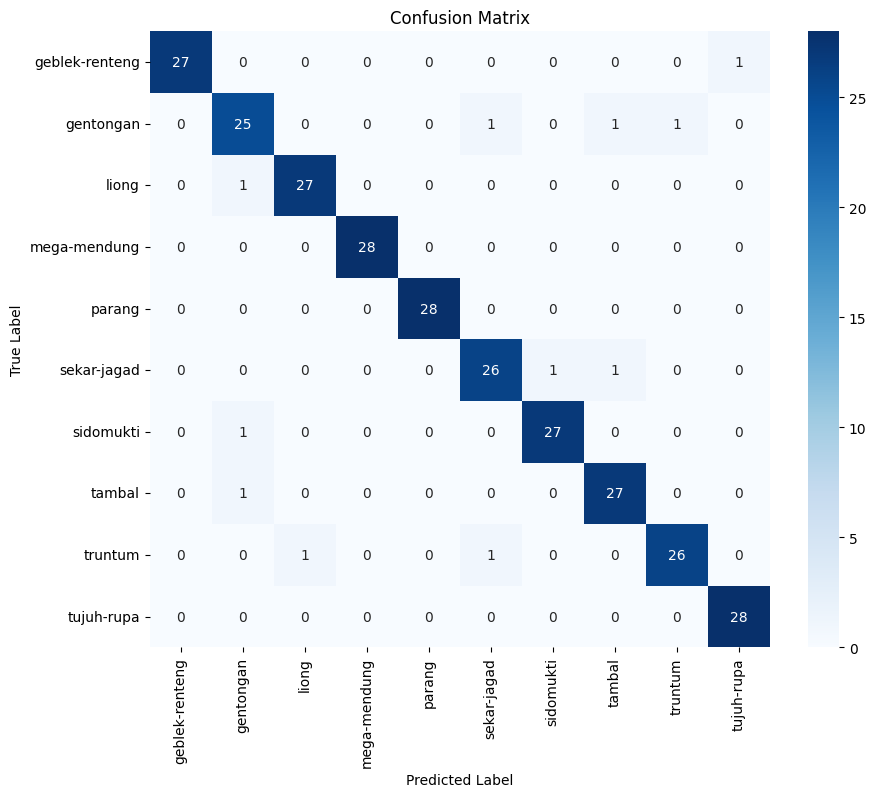

                precision    recall  f1-score   support

geblek-renteng       1.00      0.96      0.98        28
     gentongan       0.89      0.89      0.89        28
         liong       0.96      0.96      0.96        28
  mega-mendung       1.00      1.00      1.00        28
        parang       1.00      1.00      1.00        28
   sekar-jagad       0.93      0.93      0.93        28
     sidomukti       0.96      0.96      0.96        28
        tambal       0.93      0.96      0.95        28
       truntum       0.96      0.93      0.95        28
    tujuh-rupa       0.97      1.00      0.98        28

      accuracy                           0.96       280
     macro avg       0.96      0.96      0.96       280
  weighted avg       0.96      0.96      0.96       280



In [29]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [30]:
# Calculate precision, recall, and f1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.9609514687100894
Recall: 0.9607142857142857
F1 Score: 0.9607097288676237


In [32]:
model.save("model.h5")